# Basic tool calling agent from scratch

### Requirement
Create a Q&A agent that can use tools for answering questions.


https://python.langchain.com/docs/how_to/tool_calling/

In [1]:
from dotenv import load_dotenv


# CHANGE THIS TO POINT TO YOUR OWN FILE
# Load the file that contains the API keys 
load_dotenv('C:\\Users\\raj\\.jupyter\\.env')



True

## 1. Create an instance of chat model

### Create a chat LLM
https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html



In [2]:
from langchain.chat_models import init_chat_model

# Models to try out
# Supported model providers are: google_genai, anthropic, ibm, azure_openai, bedrock, ollama, 
# fireworks, openai, deepseek, cohere, mistralai, together, xai, bedrock_converse, groq, huggingface, google_anthropic_vertex, 
# perplexity, google_vertexai, azure_ai
models = [
            {"model":"gpt-4o-mini", "model_provider":"openai"},
            {"model":"claude-3-5-sonnet-latest", "model_provider":"anthropic"},
            {"model":"command-r",  "model_provider":"cohere"},
            {"model": "moonshotai/kimi-k2-instruct", "model_provider": "groq"},
            {"model": "llama-3.3-70b-versatile", "model_provider": "groq"}
    
]
chat_llm = init_chat_model(**models[3])
                            

chat_llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F5988671D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F598B20980>, model_name='moonshotai/kimi-k2-instruct', model_kwargs={}, groq_api_key=SecretStr('**********'))

## 2. Define the tools

##### 1. Setup tool functions

##### 2. Bind LLM to tools
https://python.langchain.com/docs/concepts/tool_calling/

##### 3. Define a tool node

In [3]:
from typing import TypedDict, List
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from IPython.display import Image, display


@tool
def multiply(number_1: int, number_2: int) -> int:
    """Multiply two numbers."""
    return number_1 * number_2

@tool
def add(number_1: int, number_2: int) -> int:
    """Add two numbers."""
    return number_1 + number_2

@tool
def subtract(number_1: int, number_2: int) -> int:
    """Subtract two numbers."""
    return number_1 - number_2

# Bind the tools to LLM i.e., make LLM aware of the available tools
chat_llm_with_tool = chat_llm.bind_tools([add, subtract, multiply])

# Create an instance of tool node
tool_node = ToolNode(
    name = "math_tools",
    tools = [multiply,add,subtract]
)

# chat_llm_with_tool

In [4]:
# Units testing

# input_state = {"messages": [HumanMessage(content="what is 3*2 and 5+2")]}
# response=chat_llm_with_tool.invoke(input_state["messages"])
# response

## 3. Create the agent node

In [5]:
# agent simply calls the LLM with messages
def  agent_node(state : MessagesState):
     messages = state["messages"]
     response = chat_llm_with_tool.invoke(messages)
     return {"messages": response}

## 4. Setup the graph

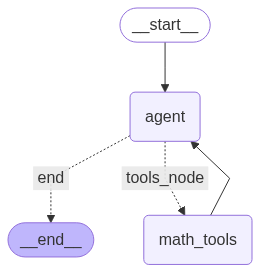

In [6]:
# State consist of the message list : HumanMessage, AIMessage, ToolMessage
agent_workflow = StateGraph(MessagesState)

# Add the nodes
agent_workflow.add_node("agent", agent_node)
agent_workflow.add_node("math_tools", tool_node)
agent_workflow.add_edge(START, "agent")

# Conditional edge : checks if the last message has tool calls then call the tools_node otherwise end
def  call_router(state):
     # Last message in the list
     last_message = state["messages"][-1]

     # If the last message is AIMessage & there is a request by AI to invoke tools route to tools_node
     if type(last_message)==AIMessage and len(last_message.tool_calls) > 0 : 
         print("router: tools")
         return "tools_node"
     else:
         print("router: end")
         return "end"
        
agent_workflow.add_conditional_edges("agent", call_router , {"end": END, "tools_node": "math_tools"})

# Tools node sends the control back to the agent; agent sends the tool results to LLM for final response
agent_workflow.add_edge("math_tools", "agent")

# Compile the workflow
agent_workflow_compiled = agent_workflow.compile()

# Display
display(Image(agent_workflow_compiled.get_graph().draw_mermaid_png()))

In [7]:
# Tests
input_state = {"messages": [HumanMessage(content="Calculate 5 * 3 and 20+65 then subtract the result of 5*3 from the other result")]}

# input_state = {"messages": [HumanMessage(content="calculate (9*2)*3+4-11")]}

# Invoke
response = agent_workflow_compiled.invoke(input_state)

response["messages"][-1].content

router: tools
router: tools
router: tools
router: end


'The final result is **70**.'